Sample multivariate-$t$ posteriors with frequentist-matching priors

In [3]:
import jax 
import jax.numpy as jnp 
import jax.random as jr
from jax.scipy.special import gammaln
import blackjax
import numpy as np
import matplotlib.pyplot as plt
from chainconsumer import Chain, ChainConsumer, Truth, PlotConfig
import pandas as pd
import tensorflow_probability.substrates.jax.distributions as tfd

from utils import load_shear_experiment, make_df

key = jr.key(0)

(
    param_names,
    alpha, 
    fiducial_dv,
    covariance,
    Cinv,
    precision,
    derivatives,
    F, 
    Finv,
    lower,
    upper
) = load_shear_experiment()

n_data = fiducial_dv.size 
n_sims = 10000

parameter_prior = tfd.Blockwise(
    [
        tfd.Uniform(low=lower[p], high=upper[p]) 
        for p in range(alpha.size)
    ]
)

def box_prior(x):
    in_box = ((lower < alpha) & (alpha < upper)).all()
    return 1. / jnp.prod(upper - lower) if in_box else -jnp.inf

# Get simulations
fiducials = jr.multivariate_normal(key, fiducial_dv, covariance, (n_sims,))

# Estimate covariance, precision and Fisher information
S = jnp.cov(fiducials.T)
S_ = jnp.linalg.inv(S)
H = (n_sims - n_data - 2.) / (n_sims - 1) # Hartlap
Finv_S = jnp.linalg.multi_dot([derivatives, S_, derivatives.T])

In [4]:
def linearized_model(_alpha, fiducial_dv, alpha, derivatives):
    return fiducial_dv + jnp.dot(_alpha - alpha, derivatives)


def t_logpdf(pi, data, shape, nu, m):
    # https://gregorygundersen.com/blog/2020/01/20/multivariate-t/    
    mean = linearized_model(pi, fiducial_dv, alpha, derivatives)

    dim = mean.size

    eigenvalues, eigenvectors = jnp.linalg.eigh(shape)
    logdet     = jnp.log(eigenvalues).sum()
    U          = eigenvectors * jnp.sqrt(1. / eigenvalues)
    dev        = data - mean
    maha       = jnp.square(jnp.dot(dev, U)).sum(axis=-1)

    t = 0.5 * (nu + dim)
    A = gammaln(t)
    B = gammaln(0.5 * nu)
    C = 0.5 * dim * np.log(nu * np.pi)
    D = 0.5 * logdet
    E = -0.5 * m * jnp.log(1. + (1. / nu) * maha) # This is df for shape matrix

    return A - B - C - D + E


def get_m(n_sims, n_data):
    # Eq 51 / 54 in Percival21
    B = (n_sims - n_data - 2) / ((n_sims - n_data - 1) * (n_sims - n_data - 4))
    m = alpha.size + 2 + (n_sims - 1 + B * (n_data - alpha.size)) / (1 + B * (n_data - alpha.size))
    return m


def dodelson(n_sims, n_data):
    # Dodelson factors
    B = (n_sims - n_data - 2.) / ((n_sims - n_data - 1.) * (n_sims - n_data - 4.))
    # Expansion-of-errors factor for likelihood with est. cov, data dimensional 
    return 1. + B * (n_data - alpha.size) 


def mle(d, Sinv):
    # Assuming accurate model + derivatives
    F_S = jnp.linalg.multi_dot([derivatives, Sinv, derivatives.T]) 
    Finv_S = jnp.linalg.inv(F_S)
    alpha_ = alpha + jnp.linalg.multi_dot([Finv_S, derivatives, Sinv, d - fiducial_dv])
    return alpha_

In [5]:
def inference_loop(rng_key, kernel, initial_state, num_samples):

    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jr.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


def inference_loop_multiple_chains(
    rng_key, kernel, initial_state, num_samples, num_chains
):

    @jax.jit
    def one_step(states, rng_key):
        keys = jr.split(rng_key, num_chains)
        states, _ = jax.vmap(kernel)(keys, states)
        return states, states

    keys = jr.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


num_chains = 1
num_samples = 200_000

inv_mass_matrix = jnp.ones_like(alpha) * 0.1 # Length of this array = number of paramters
step_size = 1e-2

# Datavector
observed = jr.multivariate_normal(key, fiducial_dv, covariance) # Must be 1D

# Same keys for sampling
key, key_init, key_sample = jr.split(key, 3)

# Same initial positions for sampling
initial_positions = {
    "pi" : jr.multivariate_normal(key_init, alpha, Finv, (num_chains,))
}

mle_ = mle(observed, S_) # No Hartlap needed here

Parameter prior for $t$-distribution posteriors is independent of covariance prior.

SH16 use $n_s$ for the index in their power law prior, meaning $m=n_s$.

In [6]:
def p21_logdensity(x): 
    # Posterior IJ-prior with exponent to give a t-distribution posterior with approximately frequentist coverage
    pi = x["pi"]
    return t_logpdf(
        pi, 
        data=observed, 
        shape=S, 
        nu=n_sims - 1, 
        m=get_m(n_sims, observed.size)
    ) + parameter_prior.log_prob(pi)


def sh16_logdensity(x): 
    # Posterior IJ-prior giving a t-distribution posterior
    pi = x["pi"]
    return t_logpdf(
        pi, 
        data=observed, 
        shape=S, 
        nu=n_sims - 1, 
        m=n_sims
    ) + parameter_prior.log_prob(pi)


def g_logdensity(x):
    # Posterior using Hartlap debiased data covariance
    pi = x["pi"]
    mu = linearized_model(pi, fiducial_dv, alpha, derivatives)
    a, b = jnp.linalg.slogdet(2. * jnp.pi * S)
    logdet = a * b
    chi2 = jnp.linalg.multi_dot([observed - mu, S_, observed - mu])
    return -0.5 * (logdet + chi2) + parameter_prior.log_prob(pi)

In [7]:
names = ["Hartlap", "SH16", "P21"]
fns = [g_logdensity, sh16_logdensity, p21_logdensity]

all_states = []
for name, fn in zip(names, fns):

    # Initialise MCMC on posterior function
    nuts = blackjax.nuts(fn, step_size, inv_mass_matrix)
    nuts_kernel = jax.jit(nuts.step)

    initial_states = jax.vmap(nuts.init)(initial_positions)

    # Sample
    states = inference_loop_multiple_chains(
        key_sample, nuts.step, initial_states, num_samples, num_chains
    )

    print(name)
    all_states.append(states)

Hartlap
SH16
P21


In [8]:
# g_logdensity(dict(pi=np.array([ 0.31218463,  0.8207797 , -1.1943669 ])))
# g_logdensity(dict(pi=alpha))

mu = linearized_model(alpha, fiducial_dv, alpha, derivatives)
chi2 = jnp.linalg.multi_dot([observed - mu, S_, observed - mu])
# -0.5 * (jnp.log(jnp.linalg.det(2. * jnp.pi * S)) + chi2)
# jnp.linalg.
# chi2

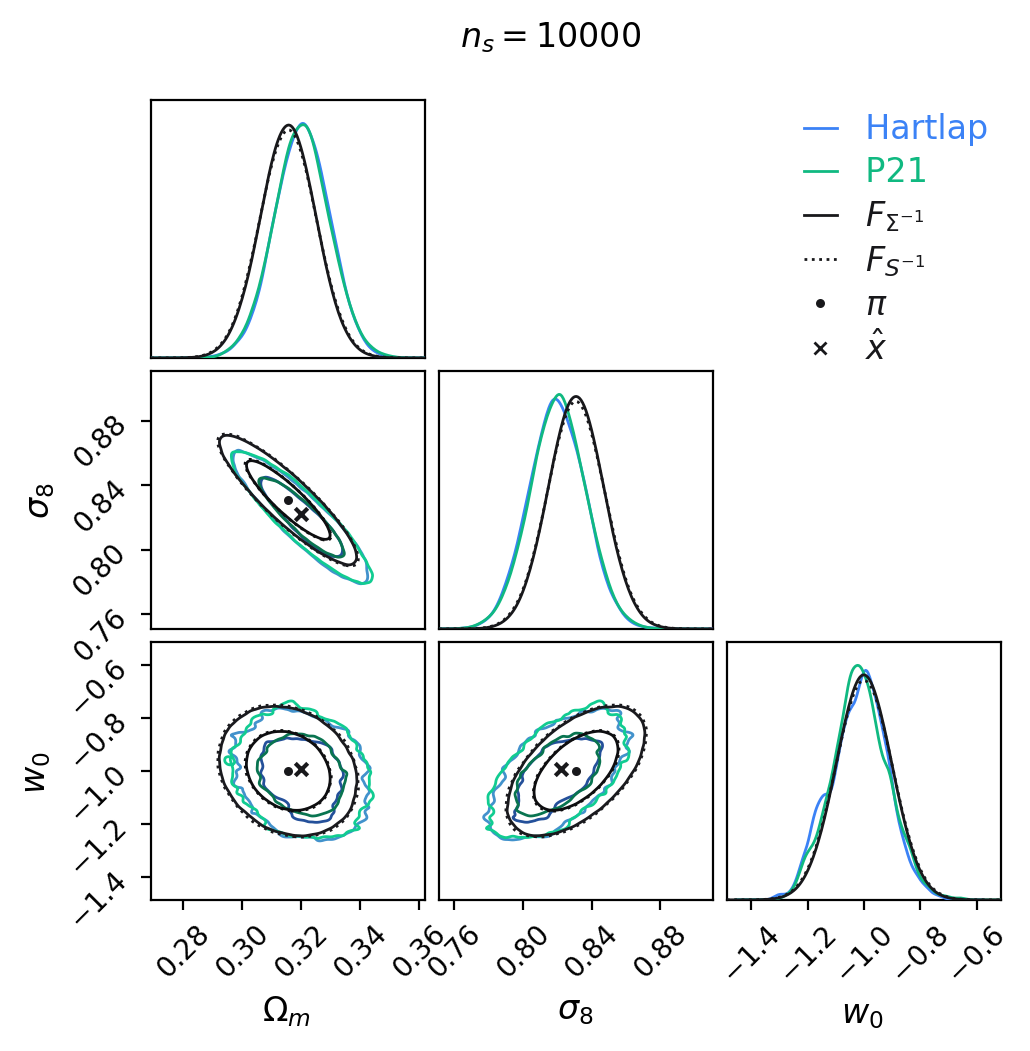

In [16]:
colors = ["r", "g", "b"]

c = ChainConsumer()

for i, (name, state) in enumerate(zip(names, all_states)):

    # if name == "SH16" or name == "Hartlap":
        # continue
    if name == "SH16":
        continue

    samples = state.position["pi"].block_until_ready()
    log_pdfs = state.logdensity

    posterior_df = make_df(samples[:, 0, :], log_pdfs[:, 0], param_names)

    c.add_chain(
        Chain(
            samples=posterior_df, 
            name=name,
            plot_cloud=False, 
            # plot_contour=False, 
            shade_alpha=0.,
            # kde=1. if name == "Hartlap" else None
        )
    )

c.add_chain(
    Chain.from_covariance(
        alpha,
        Finv,
        columns=param_names,
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        shade_alpha=0.
    )
)

c.add_chain(
    Chain.from_covariance(
        alpha,
        dodelson(n_sims, n_data) * Finv,
        columns=param_names,
        name=r"$F_{S^{-1}}$",
        color="k",
        shade_alpha=0.,
        linestyle=":"
    )
)

c.add_marker(
    location=dict(zip(param_names, np.asarray(alpha))), name=r"$\pi$", color="k"
)
c.add_marker(
    location=dict(zip(param_names, np.asarray(mle_))), name=r"$\hat{x}$", color="k", marker_style="x"
)

k = 5
c.set_plot_config(
    PlotConfig(
        extents=dict(
            zip(
                param_names,
                [
                    [
                        alpha[p] - k * np.sqrt(np.diag(Finv))[p], 
                        alpha[p] + k * np.sqrt(np.diag(Finv))[p]
                    ] for p in range(alpha.size)
                ]
            )
        )
    )
)
fig = c.plotter.plot()
fig.set_dpi(200)
fig.set_figwidth(5.)
fig.set_figheight(5.)
fig.suptitle(fr"$n_s={n_sims}$")
plt.savefig("posteriors.png", bbox_inches="tight")
plt.show()

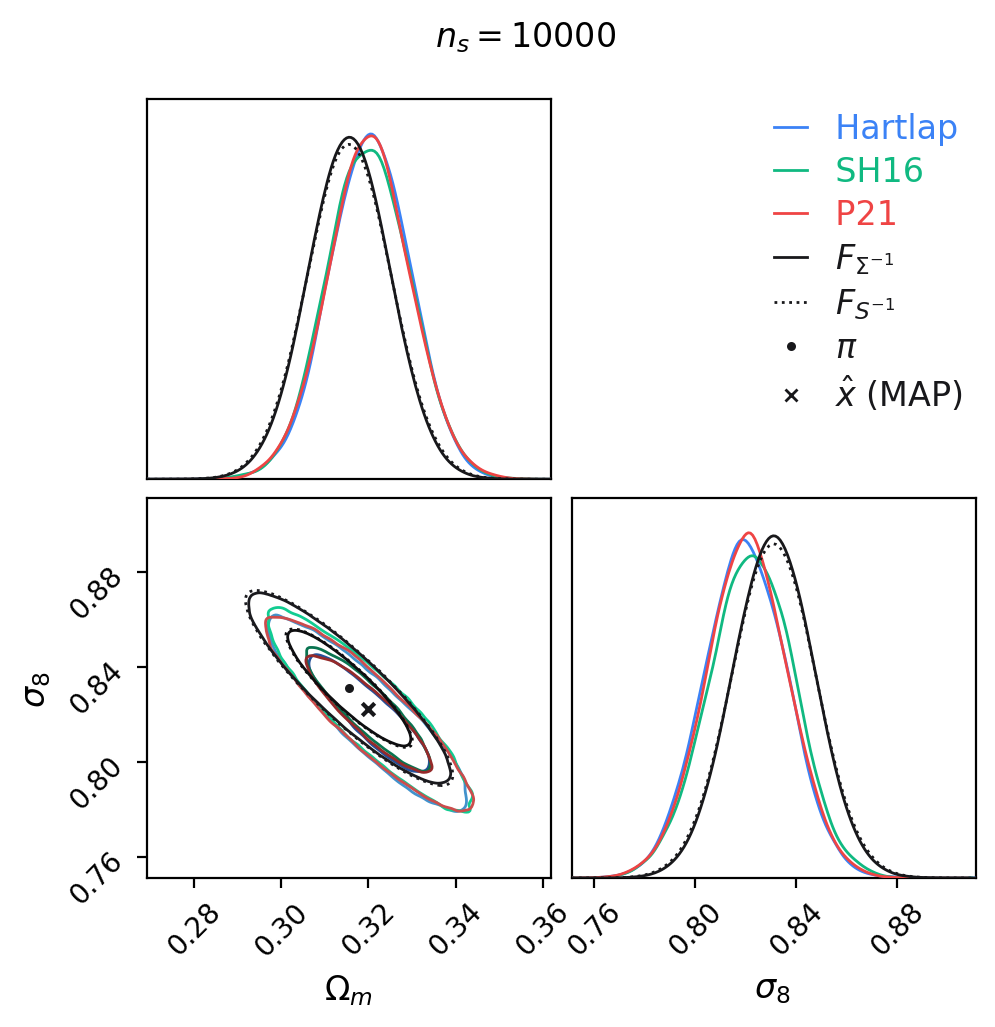

In [10]:
c = ChainConsumer()

for name, state in zip(names, all_states):

    samples = state.position["pi"].block_until_ready()
    log_pdfs = state.logdensity


    posterior_df = make_df(samples[:, 0, :2], log_pdfs[:, 0], param_names[:2])

    c.add_chain(
        Chain(
            samples=posterior_df, 
            name=name,
            plot_cloud=False, 
            shade_alpha=0.,
        )
    )

c.add_chain(
    Chain.from_covariance(
        alpha[:2],
        Finv[:, :2][:2, :],
        columns=param_names[:2],
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        shade_alpha=0.
    )
)

c.add_chain(
    Chain.from_covariance(
        alpha[:2],
        dodelson(n_sims, n_data) * Finv[:, :2][:2, :],
        columns=param_names[:2],
        name=r"$F_{S^{-1}}$",
        color="k",
        shade_alpha=0.,
        linestyle=":"
    )
)

c.add_marker(location=dict(zip(param_names[:2], np.asarray(alpha)[:2])), name=r"$\pi$", color="k")
c.add_marker(location=dict(zip(param_names[:2], np.asarray(mle_)[:2])), name=r"$\hat{x}$ (MAP)", color="k", marker_style="x")

k = 5
c.set_plot_config(
    PlotConfig(
        extents=dict(
            zip(
                param_names[:2],
                [
                    [
                        alpha[p] - k * np.sqrt(np.diag(Finv))[p], 
                        alpha[p] + k * np.sqrt(np.diag(Finv))[p]
                    ] for p in range(alpha.size - 1)
                ]
            )
        )
    )
)
fig = c.plotter.plot()
fig.suptitle(fr"$n_s={n_sims}$")
fig.set_dpi(200)
fig.set_figwidth(5.)
fig.set_figheight(5.)
plt.savefig("posteriors_marginalised.png", bbox_inches="tight")
plt.show()